In [18]:
import random
import csv
import math
import numpy as np
import time
import operator
import matplotlib.pyplot as plt
import pickle
import heapq

In [19]:
live_edges_20k_point001_point3_steps = pickle.load(open("live_edges_20k_point001_point3_steps", "rb"))

live_edges_20k_point001_point5_steps = pickle.load(open("live_edges_20k_point001_point5_steps", "rb"))

live_edges_20k_point005_point3_steps = pickle.load(open("live_edges_20k_point005_point3_steps", "rb"))

live_edges_20k_point005_point5_steps = pickle.load(open("live_edges_20k_point005_point5_steps", "rb"))

In [20]:
def celf_steps_live_edges(p_initial_infect, p_infect, lists_infected_dicts, num_detectors, n=2029, debug=False):
    
    runs_per_marginal_node = len(lists_infected_dicts)
    
    print('Running CELF to minimize simulation steps w/ live edges')
    results = open("CELF_steps_live_edges.txt", "w")
    results.write("P_infect = " + str(p_infect) + " P_initial_infect = " + str(p_initial_infect) + " Runs per marginal node = " + str(runs_per_marginal_node))
    results.write("\nNode ID\tReward so Far\tMarginal gain\tRuntime (minutes)\n")
    
    final_steps = []
    final_runtimes = []
    
    rewards_so_far = 39265
    
    marginals = []
    start_time = time.time()
    
    # how to calculate simulation steps: look thru the keys in the dictionary, if it is not in the keys, then we automatically fill it w/ the max number of simulation steps
    for potential_detector in range(1,n+1): # calculate marginals for each node
        runs = [infected_dict[potential_detector] if potential_detector in infected_dict.keys() else 39265 for infected_dict in lists_infected_dicts]
        heapq.heappush(marginals, (sum(runs)/float(runs_per_marginal_node) - rewards_so_far, potential_detector))
    
    best_tuple = heapq.heappop(marginals)
    best_node = best_tuple[1]
    marginal = best_tuple[0]
    rewards_so_far = marginal + rewards_so_far
    runtime = ( time.time() - start_time ) / 60
    selected_detectors = [best_node] # we have found our first best node
    
    print("We have our first best node: ")
    print(selected_detectors)
    print("Runtime (minutes) = " + str( runtime ))
    final_steps.append(rewards_so_far)
    final_runtimes.append(runtime)
    
    results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(marginal) + '\t' + str(runtime) + '\n' )
    
    for i in range(1, num_detectors): # select the next 19 detectors
        
        if debug:
            print("Trying to find the " + str(i+1) + "th detector" )
        
        # need to re-evaluate the top node once, at least
        old_top_tuple = heapq.heappop(marginals)
        old_top_node = old_top_tuple[1]
        new_detectors = list(selected_detectors)
        new_detectors.append(old_top_node)

        # lazily evaluate for the top node
        runs = [] # records the results for each run
        for run in range(runs_per_marginal_node): # go thru the runs
            infected_dict = lists_infected_dicts[run]
            if bool(set(new_detectors) & set(infected_dict.keys() )): # detector is in the set of infected ids
                alerted_detectors = set(new_detectors) & set(infected_dict.keys() )  # grab the set of detectors that was alerted
                alert_times = [infected_dict[detector] for detector in alerted_detectors]
                runs.append(min(alert_times)) # get the first time of alert
            else: # outbreak not detected, so last simulation step
                runs.append(39265)
            
        heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, old_top_node))
        new_top_tuple = heapq.heappop(marginals)
        new_top_node = new_top_tuple[1]
        
        while new_top_node != old_top_node: # this is where we need to re-evaluate the next top node
            old_top_node = new_top_node
            new_detectors = list(selected_detectors)
            new_detectors.append(old_top_node)
            
            runs = [] # records number of runs
            for run in range(runs_per_marginal_node): # go thru the runs
                infected_dict = lists_infected_dicts[run]
                if bool(set(new_detectors) & set(infected_dict.keys())): # detector is in the set of infected ids
                    alerted_detectors = set(new_detectors) & set(infected_dict.keys() ) # grab the set of detectors that was alerted
                    alert_times = [infected_dict[detector] for detector in alerted_detectors]
                    runs.append(min(alert_times)) # get the first time of alert
                else: # outbreak not detected, so last simulation step
                    runs.append(39265)            
            
            heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, old_top_node))

            new_top_tuple = heapq.heappop(marginals)
            new_top_node = new_top_tuple[1]
        
        best_node = new_top_node
        
        print("After doing CELF, we have found the " + str (i+1) + "th detector w/ best marginal gain = " + str(best_node))
        selected_detectors.append(best_node)
        runtime = (time.time() - start_time)/60
        rewards_so_far = rewards_so_far + new_top_tuple[0] # update the rewards w/ the marginals gained by the current node
        results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(new_top_tuple[0]) + '\t' + str(runtime) + '\n')
        final_steps.append(rewards_so_far)
        final_runtimes.append(runtime)
        print("Simulation steps so far: " + str(rewards_so_far))
        print("Runtime (minutes) = " + str(runtime))
        
        
            
    results.close()
    return final_steps, final_runtimes
    

# CELF

# Pure Social Score

In [21]:
def social_steps_live_edges(p_initial_infect, p_infect, lists_infected_dicts, num_detectors):

    final_steps = []
    final_runtimes = []
    
    with open("socialScore_modified_unpruned.txt") as social_file:
        lines = social_file.readlines()
        social_score_nodes = []
        for line in lines:
            social_score_nodes.append( int(line.split()[0]) )
    runs_per_marginal_node = len(lists_infected_dicts)
            
    rewards_so_far = 0
    marginal = 0
    start_time = time.time()
    selected_detectors = []
    for next_detector in range(num_detectors):
        selected_detectors.append(social_score_nodes[next_detector]) # add the next detector
        
        runs = [] # records number of runs
        for run in range(runs_per_marginal_node): # go thru the runs
            infected_dict = lists_infected_dicts[run]
            if bool(set(selected_detectors) & set(infected_dict.keys())): # detector is in the set of infected ids
                alerted_detectors = set(selected_detectors) & set(infected_dict.keys() ) # grab the set of detectors that was alerted
                alert_times = [infected_dict[detector] for detector in alerted_detectors]
                runs.append(min(alert_times)) # get the first time of alert
            else: # outbreak not detected, so last simulation step
                runs.append(39265) 
                    
        steps = sum(runs) / float(runs_per_marginal_node)
        marginal = steps - rewards_so_far
        rewards_so_far = steps
        final_steps.append(rewards_so_far)
        print("After doing Social Score, we have found the " + str(next_detector+1) + "th detector = " + str(social_score_nodes[next_detector]))
        print("Population affected so far: " + str(rewards_so_far))
        print("Marginal gain = " + str(marginal))
        runtime = (time.time() - start_time) / 60
        print("Runtime (minutes) = " + str(runtime))
        final_runtimes.append(runtime)
    
    return final_steps, final_runtimes



# Speed up

In [22]:
def speedup_steps_live_edges(p_initial_infect, p_infect, lists_infected_dicts, num_detectors, social_score_file, seed=0, n=2029, debug=False):
    
    runs_per_marginal_node = len(lists_infected_dicts)
    final_steps = []
    final_runtimes = []
    
    print('Running Speedup to minimize steps affected w/ live edges')
    results = open("Speedup_steps_live_edge.txt", "w")
    results.write("P_infect = " + str(p_infect) + " P_initial_infect = " + str(p_initial_infect) + " Runs per marginal node = " + str(runs_per_marginal_node))
    results.write("\nNode ID\tReward so Far\tMarginal gain\tRuntime (minutes)\n")
    
    rewards_so_far = 39265
    
    marginals = [] # heap to track marginals
    
    # how we keep track of the social score nodes
    social_score_nodes = []
    with open(social_score_file) as social_file:
        lines = social_file.readlines()
        for line in lines:
            social_score_nodes.append( int(line.split()[0]) )   
   
    
    look_ahead = int(math.sqrt(n)) # how much we look ahead
    start_time = time.time()
    
    # we are calculated population saved
    # if the detector is in the infected nodes, we take the index of the detector b/c the infected nodes are in chronological order + 1 - length to represent how many we saved
    # if not, we just take 0 b/c we didnt save any
    # select the first node by exhuastively computing all marginal benefits
    # our metric = (population affected w/ detector) - population affected w/o detector
    # we are trying to minimize this metric
    for potential_detector in social_score_nodes[:look_ahead]: # calculate marginals for each node
        runs = [infected_dict[potential_detector] if potential_detector in infected_dict.keys() else 39265 for infected_dict in lists_infected_dicts]
        heapq.heappush(marginals, (sum(runs)/float(runs_per_marginal_node) - rewards_so_far, potential_detector))

        
    
    best_tuple = heapq.heappop(marginals)
    best_node = best_tuple[1]
    marginal = best_tuple[0]
    rewards_so_far = marginal + rewards_so_far
    
    selected_detectors = [best_node] # we have found our first best node
    
    print("We have our first best node: ")
    print(selected_detectors)
    runtime = (time.time() - start_time) / 60
    print("Runtime (minutes) = " + str( runtime ))
    final_steps.append(rewards_so_far)
    final_runtimes.append(runtime)
    
    results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(marginal) + '\t' + str(runtime) + '\n' )
    
    for i in range(1, num_detectors): # select the next num_detectors-1 detectors
        
        if debug:
            print("Trying to find the " + str(i+1) + "th detector")
        
        # add one new detector from social score
        new_detectors=list(selected_detectors)
        additional_detector = social_score_nodes[look_ahead - 1 + i]
        new_detectors.append(additional_detector)
        runs = [] # records the results for each run
        for run in range(runs_per_marginal_node): # go thru the runs
            infected_dict = lists_infected_dicts[run]
            if bool(set(new_detectors) & set(infected_dict.keys())): # detector is in the set of infected ids
                alerted_detectors = set(new_detectors) & set(infected_dict.keys() ) # grab the set of detectors that was alerted
                alert_times = [infected_dict[detector] for detector in alerted_detectors]
                runs.append(min(alert_times)) # get the first time of alert
            else: # outbreak not detected, so last simulation step
                runs.append(39265) 
        heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, additional_detector))
        
        
        # need to re-evaluate the top node once, at least
        old_top_tuple = heapq.heappop(marginals)
        old_top_node = old_top_tuple[1]
        new_detectors = list(selected_detectors)
        new_detectors.append(old_top_node)

        # lazily evaluate for the top node
        runs = [] # records the results for each run
        for run in range(runs_per_marginal_node): # go thru the runs
            infected_dict = lists_infected_dicts[run]
            if bool(set(new_detectors) & set(infected_dict.keys())): # detector is in the set of infected ids
                alerted_detectors = set(new_detectors) & set(infected_dict.keys() ) # grab the set of detectors that was alerted
                alert_times = [infected_dict[detector] for detector in alerted_detectors]
                runs.append(min(alert_times)) # get the first time of alert
            else: # outbreak not detected, so last simulation step
                runs.append(39265) 
        heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, old_top_node))

        new_top_tuple = heapq.heappop(marginals)
        new_top_node = new_top_tuple[1]
        
        while new_top_node != old_top_node: # this is where we need to re-evaluate the next top node
            old_top_node = new_top_node
            new_detectors = list(selected_detectors)
            new_detectors.append(old_top_node)
            
            runs = [] # records number of runs
            for run in range(runs_per_marginal_node): # go thru the runs
                infected_dict = lists_infected_dicts[run]
                if bool(set(new_detectors) & set(infected_dict.keys())): # detector is in the set of infected ids
                    alerted_detectors = set(new_detectors) & set(infected_dict.keys() ) # grab the set of detectors that was alerted
                    alert_times = [infected_dict[detector] for detector in alerted_detectors]
                    runs.append(min(alert_times)) # get the first time of alert
                else: # outbreak not detected, so last simulation step
                    runs.append(39265)           
            heapq.heappush(marginals, (sum(runs) / float(runs_per_marginal_node) - rewards_so_far, old_top_node))
           
            new_top_tuple = heapq.heappop(marginals)
            new_top_node = new_top_tuple[1]
        
        
        
        best_node = new_top_node
        
        print("After doing speed up, we have found the " + str (i+1) + "th detector w/ best marginal gain = " + str(best_node))
        selected_detectors.append(best_node)
        runtime = (time.time() - start_time)/60
        rewards_so_far = rewards_so_far + new_top_tuple[0] # update the rewards w/ the marginals gained by the current node
        results.write(str(best_node) + '\t' + str(rewards_so_far) + '\t' + str(new_top_tuple[0]) + '\t' + str(runtime) + '\n')
        final_steps.append(rewards_so_far)
        final_runtimes.append(runtime)
        print("Steps so far: " + str(rewards_so_far))
        print("Runtime (minutes) = " + str(runtime))
        
        
        
            
    results.close()
    
    return final_steps, final_runtimes

# Comparisons

P_initial = 0.001, p_infect = 0.3

In [23]:
celf_steps_point001_point3, celf_steps_runtimes_point001_point3 = celf_steps_live_edges(0.001, 0.3, live_edges_20k_point001_point3_steps[:10000], 50)

Running CELF to minimize simulation steps w/ live edges
We have our first best node: 
[1144]
Runtime (minutes) = 0.15592358112335206
After doing CELF, we have found the 2th detector w/ best marginal gain = 246
Simulation steps so far: 28959.9457
Runtime (minutes) = 5.312134110927582
After doing CELF, we have found the 3th detector w/ best marginal gain = 453
Simulation steps so far: 28499.4791
Runtime (minutes) = 5.618502505620321
After doing CELF, we have found the 4th detector w/ best marginal gain = 1377
Simulation steps so far: 28234.5585
Runtime (minutes) = 6.111821830272675
After doing CELF, we have found the 5th detector w/ best marginal gain = 1952
Simulation steps so far: 28058.8089
Runtime (minutes) = 6.489789378643036
After doing CELF, we have found the 6th detector w/ best marginal gain = 547
Simulation steps so far: 27895.1815
Runtime (minutes) = 6.57599302927653
After doing CELF, we have found the 7th detector w/ best marginal gain = 1701
Simulation steps so far: 27761.90

In [24]:
social_steps_point001_point3, social_steps_runtimes_point001_point3 = social_steps_live_edges(0.001, 0.3, live_edges_20k_point001_point3_steps[:10000], 50)

After doing Social Score, we have found the 1th detector = 1874
Population affected so far: 29801.0964
Marginal gain = 29801.0964
Runtime (minutes) = 0.007054821650187174
After doing Social Score, we have found the 2th detector = 1258
Population affected so far: 29773.9921
Marginal gain = -27.104299999999057
Runtime (minutes) = 0.014376664161682129
After doing Social Score, we have found the 3th detector = 1669
Population affected so far: 29435.3718
Marginal gain = -338.6202999999987
Runtime (minutes) = 0.023390487829844157
After doing Social Score, we have found the 4th detector = 999
Population affected so far: 29427.4217
Marginal gain = -7.950100000001839
Runtime (minutes) = 0.02975796858469645
After doing Social Score, we have found the 5th detector = 511
Population affected so far: 29420.6965
Marginal gain = -6.725200000000768
Runtime (minutes) = 0.03714094559351603
After doing Social Score, we have found the 6th detector = 585
Population affected so far: 29416.5969
Marginal gain 

After doing Social Score, we have found the 47th detector = 993
Population affected so far: 28515.8434
Marginal gain = -17.555599999999686
Runtime (minutes) = 0.39530285596847536
After doing Social Score, we have found the 48th detector = 713
Population affected so far: 28508.5974
Marginal gain = -7.246000000002823
Runtime (minutes) = 0.4051911314328512
After doing Social Score, we have found the 49th detector = 702
Population affected so far: 28505.6209
Marginal gain = -2.9764999999970314
Runtime (minutes) = 0.4127366065979004
After doing Social Score, we have found the 50th detector = 350
Population affected so far: 28500.4256
Marginal gain = -5.195300000003044
Runtime (minutes) = 0.4202604134877523


In [25]:
speedup_steps_point001_point3, speedup_steps_runtimes_point001_point3 = speedup_steps_live_edges(0.001, 0.3, live_edges_20k_point001_point3_steps[:10000], 50, "socialScore_modified_unpruned.txt")

Running Speedup to minimize steps affected w/ live edges
We have our first best node: 
[1144]
Runtime (minutes) = 0.0037093043327331545
After doing speed up, we have found the 2th detector w/ best marginal gain = 453
Steps so far: 29164.4228
Runtime (minutes) = 0.2831255873044332
After doing speed up, we have found the 3th detector w/ best marginal gain = 1706
Steps so far: 29065.9818
Runtime (minutes) = 0.3816171526908875
After doing speed up, we have found the 4th detector w/ best marginal gain = 1874
Steps so far: 28988.7347
Runtime (minutes) = 0.4210412859916687
After doing speed up, we have found the 5th detector w/ best marginal gain = 278
Steps so far: 28924.1959
Runtime (minutes) = 0.49244871536890666
After doing speed up, we have found the 6th detector w/ best marginal gain = 1159
Steps so far: 28866.5109
Runtime (minutes) = 0.518852166334788
After doing speed up, we have found the 7th detector w/ best marginal gain = 480
Steps so far: 28815.496
Runtime (minutes) = 0.545513153

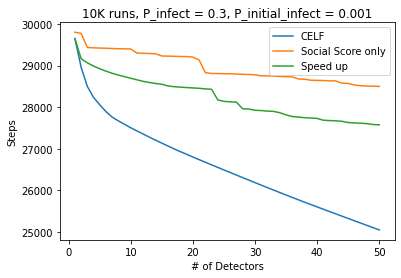

In [26]:
plt.plot(range(1, 51), celf_steps_point001_point3, label="CELF")
plt.plot(range(1, 51), social_steps_point001_point3, label="Social Score only")
plt.plot(range(1, 51), speedup_steps_point001_point3, label="Speed up")
plt.title("10K runs, P_infect = 0.3, P_initial_infect = 0.001")
plt.ylabel("Steps")
plt.xlabel("# of Detectors")
plt.legend()

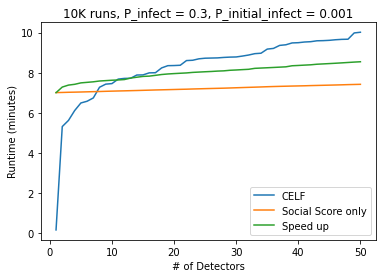

In [27]:
plt.plot(range(1, 51), celf_steps_runtimes_point001_point3, label="CELF")
plt.plot(range(1, 51), [runtime + 7 for runtime in social_steps_runtimes_point001_point3], label="Social Score only")
plt.plot(range(1, 51), [runtime + 7 for runtime in speedup_steps_runtimes_point001_point3], label="Speed up")
plt.title("10K runs, P_infect = 0.3, P_initial_infect = 0.001")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

P_initial = 0.001, p_infect = 0.5

In [28]:
celf_steps_point001_point5, celf_steps_runtimes_point001_point5 = celf_steps_live_edges(0.001, 0.5, live_edges_20k_point001_point5_steps[:10000], 50)

Running CELF to minimize simulation steps w/ live edges
We have our first best node: 
[1144]
Runtime (minutes) = 0.16849424044291178
After doing CELF, we have found the 2th detector w/ best marginal gain = 246
Simulation steps so far: 26098.5816
Runtime (minutes) = 8.055144309997559
After doing CELF, we have found the 3th detector w/ best marginal gain = 453
Simulation steps so far: 25681.1171
Runtime (minutes) = 8.556663862864177
After doing CELF, we have found the 4th detector w/ best marginal gain = 1377
Simulation steps so far: 25390.8448
Runtime (minutes) = 8.977201704184214
After doing CELF, we have found the 5th detector w/ best marginal gain = 1952
Simulation steps so far: 25146.1096
Runtime (minutes) = 9.351777982711791
After doing CELF, we have found the 6th detector w/ best marginal gain = 547
Simulation steps so far: 24964.3369
Runtime (minutes) = 9.77927151521047
After doing CELF, we have found the 7th detector w/ best marginal gain = 1701
Simulation steps so far: 24797.06

In [29]:
social_steps_point001_point5, social_steps_runtimes_point001_point5 = social_steps_live_edges(0.001, 0.5, live_edges_20k_point001_point5_steps[:10000], 50)

After doing Social Score, we have found the 1th detector = 1874
Population affected so far: 27163.7793
Marginal gain = 27163.7793
Runtime (minutes) = 0.008793361981709798
After doing Social Score, we have found the 2th detector = 1258
Population affected so far: 27141.7151
Marginal gain = -22.064199999997072
Runtime (minutes) = 0.01900316874186198
After doing Social Score, we have found the 3th detector = 1669
Population affected so far: 26828.3899
Marginal gain = -313.32520000000295
Runtime (minutes) = 0.027316959698994954
After doing Social Score, we have found the 4th detector = 999
Population affected so far: 26823.1332
Marginal gain = -5.256699999998091
Runtime (minutes) = 0.03523029883702596
After doing Social Score, we have found the 5th detector = 511
Population affected so far: 26814.9356
Marginal gain = -8.197599999999511
Runtime (minutes) = 0.04484988451004028
After doing Social Score, we have found the 6th detector = 585
Population affected so far: 26812.0823
Marginal gain 

After doing Social Score, we have found the 48th detector = 713
Population affected so far: 26053.8633
Marginal gain = -7.405699999999342
Runtime (minutes) = 0.4818385004997253
After doing Social Score, we have found the 49th detector = 702
Population affected so far: 26052.6154
Marginal gain = -1.2479000000021188
Runtime (minutes) = 0.4948515733083089
After doing Social Score, we have found the 50th detector = 350
Population affected so far: 26049.8052
Marginal gain = -2.8101999999998952
Runtime (minutes) = 0.5062536478042603


In [30]:
speedup_steps_point001_point5, speedup_steps_runtimes_point001_point5 = speedup_steps_live_edges(0.001, 0.5, live_edges_20k_point001_point5_steps[:10000], 50 , "socialScore_modified_unpruned.txt")

Running Speedup to minimize steps affected w/ live edges
We have our first best node: 
[1144]
Runtime (minutes) = 0.004642947514851888
After doing speed up, we have found the 2th detector w/ best marginal gain = 453
Steps so far: 26625.1043
Runtime (minutes) = 0.4102879842122396
After doing speed up, we have found the 3th detector w/ best marginal gain = 1706
Steps so far: 26545.3166
Runtime (minutes) = 0.5940780560175578
After doing speed up, we have found the 4th detector w/ best marginal gain = 278
Steps so far: 26474.2686
Runtime (minutes) = 0.6646304329236349
After doing speed up, we have found the 5th detector w/ best marginal gain = 1874
Steps so far: 26418.9675
Runtime (minutes) = 0.7340340614318848
After doing speed up, we have found the 6th detector w/ best marginal gain = 895
Steps so far: 26366.0733
Runtime (minutes) = 0.7748173475265503
After doing speed up, we have found the 7th detector w/ best marginal gain = 1159
Steps so far: 26323.9286
Runtime (minutes) = 0.844841587

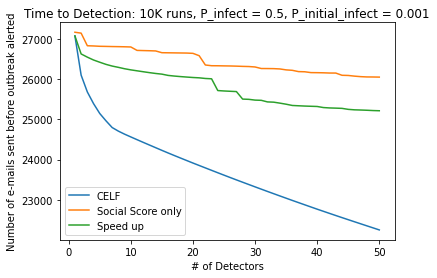

In [31]:
plt.plot(range(1, 51), celf_steps_point001_point5, label="CELF")
plt.plot(range(1, 51), social_steps_point001_point5, label="Social Score only")
plt.plot(range(1, 51), speedup_steps_point001_point5, label="Speed up")
plt.title("Time to Detection: 10K runs, P_infect = 0.5, P_initial_infect = 0.001")
plt.ylabel("Number of e-mails sent before outbreak alerted")
plt.xlabel("# of Detectors")
plt.legend()

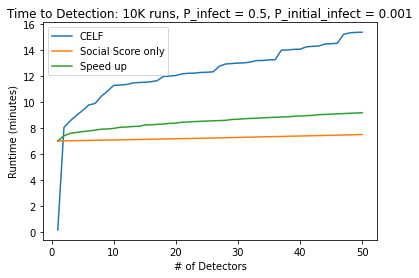

In [32]:
plt.plot(range(1, 51), celf_steps_runtimes_point001_point5, label="CELF")
plt.plot(range(1, 51), [runtime + 7 for runtime in social_steps_runtimes_point001_point5], label="Social Score only")
plt.plot(range(1, 51), [runtime + 7 for runtime in speedup_steps_runtimes_point001_point5], label="Speed up")
plt.title("Time to Detection: 10K runs, P_infect = 0.5, P_initial_infect = 0.001")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()

P_initial = 0.005, p_infect = 0.3

In [33]:
celf_steps_point005_point3, celf_steps_runtimes_point005_point3 = celf_steps_live_edges(0.005, 0.3, live_edges_20k_point005_point3_steps[:500], 50)

Running CELF to minimize simulation steps w/ live edges
We have our first best node: 
[1144]
Runtime (minutes) = 0.01248627503712972
After doing CELF, we have found the 2th detector w/ best marginal gain = 246
Simulation steps so far: 8992.028
Runtime (minutes) = 0.8740156094233195
After doing CELF, we have found the 3th detector w/ best marginal gain = 453
Simulation steps so far: 8308.506
Runtime (minutes) = 0.9521722555160522
After doing CELF, we have found the 4th detector w/ best marginal gain = 1377
Simulation steps so far: 8007.15
Runtime (minutes) = 1.24010910987854
After doing CELF, we have found the 5th detector w/ best marginal gain = 399
Simulation steps so far: 7786.008
Runtime (minutes) = 1.416157639026642
After doing CELF, we have found the 6th detector w/ best marginal gain = 1548
Simulation steps so far: 7565.604
Runtime (minutes) = 1.4169047395388286
After doing CELF, we have found the 7th detector w/ best marginal gain = 861
Simulation steps so far: 7354.0
Runtime (m

In [34]:
social_steps_point005_point3, social_steps_runtimes_point005_point3 = social_steps_live_edges(0.005, 0.3, live_edges_20k_point005_point3_steps[:1000], 50)

After doing Social Score, we have found the 1th detector = 1874
Population affected so far: 10606.572
Marginal gain = 10606.572
Runtime (minutes) = 0.005902274449666341
After doing Social Score, we have found the 2th detector = 1258
Population affected so far: 10537.514
Marginal gain = -69.0580000000009
Runtime (minutes) = 0.00831244389216105
After doing Social Score, we have found the 3th detector = 1669
Population affected so far: 9949.166
Marginal gain = -588.348
Runtime (minutes) = 0.011811582247416179
After doing Social Score, we have found the 4th detector = 999
Population affected so far: 9918.016
Marginal gain = -31.149999999999636
Runtime (minutes) = 0.014037907123565674
After doing Social Score, we have found the 5th detector = 511
Population affected so far: 9898.551
Marginal gain = -19.465000000000146
Runtime (minutes) = 0.01687467892964681
After doing Social Score, we have found the 6th detector = 585
Population affected so far: 9877.99
Marginal gain = -20.560999999999694


After doing Social Score, we have found the 50th detector = 350
Population affected so far: 7973.83
Marginal gain = -20.56999999999971
Runtime (minutes) = 0.10635383129119873


In [35]:
speedup_steps_point005_point3, speedup_steps_runtimes_point005_point3 = speedup_steps_live_edges(0.005, 0.3, live_edges_20k_point005_point3_steps[:1000], 50, "socialScore_modified_unpruned.txt")

Running Speedup to minimize steps affected w/ live edges
We have our first best node: 
[1144]
Runtime (minutes) = 0.0004826068878173828
After doing speed up, we have found the 2th detector w/ best marginal gain = 453
Steps so far: 9596.43
Runtime (minutes) = 0.07114049593607584
After doing speed up, we have found the 3th detector w/ best marginal gain = 1874
Steps so far: 9404.049
Runtime (minutes) = 0.1000081976254781
After doing speed up, we have found the 4th detector w/ best marginal gain = 895
Steps so far: 9230.804
Runtime (minutes) = 0.10585713783899943
After doing speed up, we have found the 5th detector w/ best marginal gain = 1706
Steps so far: 9105.938
Runtime (minutes) = 0.13662901719411213
After doing speed up, we have found the 6th detector w/ best marginal gain = 1159
Steps so far: 8985.561
Runtime (minutes) = 0.1468189239501953
After doing speed up, we have found the 7th detector w/ best marginal gain = 278
Steps so far: 8884.897
Runtime (minutes) = 0.15566109816233317


In [36]:
celf_1k_runtimes = celf_steps_runtimes_point005_point3

In [37]:
celf_500_runtimes = celf_steps_runtimes_point005_point3

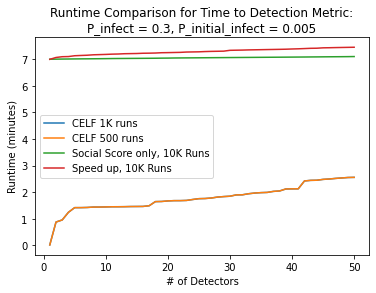

In [38]:
plt.plot(range(1, 51), celf_1k_runtimes, label="CELF 1K runs")
plt.plot(range(1, 51), celf_500_runtimes, label="CELF 500 runs")
plt.plot(range(1, 51), [runtime + 7 for runtime in social_steps_runtimes_point005_point3], label="Social Score only, 10K Runs")
plt.plot(range(1, 51), [runtime + 7 for runtime in speedup_steps_runtimes_point005_point3], label="Speed up, 10K Runs")
plt.title("Runtime Comparison for Time to Detection Metric:\nP_infect = 0.3, P_initial_infect = 0.005")
plt.ylabel("Runtime (minutes)")
plt.xlabel("# of Detectors")
plt.legend()